<a href="https://colab.research.google.com/github/tigerak/1st_practice/blob/main/M5_%EB%82%98%EC%9D%B4%EB%B8%8C%EB%B2%A0%EC%9D%B4%EC%A6%88%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 나이브 베이즈 분류기

- 베이즈 정리를 적용한 확률적 알고리즘
- 모든 특성들이 독립임을 가정 (naive 가정)
- 입력 특성에 따라 3개의 분류기 존재
 - 가우시안 NVC
 - 베르누이 NVC
 - 다항 NVC

# 나이브 베이즈 분류기의 확률 모델
- 나이브 베이즈는 조건부 확률 모델
- N개의 특성을 나타내는 벡터 x를 입력받아 k개의 가능한 확률적 결과를 출력
- 식을 통해 나온 값들 중 가장 큰 값을 갖는 클래스가 예측 결과 
  - y_hat = argmax(X)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs

from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn import metrics

from sklearn.datasets import fetch_covtype, fetch_20newsgroups

In [66]:
prior = [0.45, 0.3, 0.15, 0.1]
likelihood = [[0.3, 0.3, 0.4], [0.7, 0.2, 0.1], [0.15, 0.5, 0.35], [0.6, 0.2, 0.2]]

idx = 0
for c, xs in zip(prior, likelihood):
    result = 1.

    for x in xs :
        result *= x
    result *= c

    idx += 1
    print(f'{idx}번째 class의 가능성 : {result}')

1번째 class의 가능성 : 0.0162
2번째 class의 가능성 : 0.0042
3번째 class의 가능성 : 0.0039375
4번째 class의 가능성 : 0.0024000000000000002


## 산림 토양 데이터

In [67]:
covtype = fetch_covtype()
print(covtype.DESCR)

.. _covtype_dataset:

Forest covertypes
-----------------

The samples in this dataset correspond to 30×30m patches of forest in the US,
collected for the task of predicting each patch's cover type,
i.e. the dominant species of tree.
There are seven covertypes, making this a multiclass classification problem.
Each sample has 54 features, described on the
`dataset's homepage <https://archive.ics.uci.edu/ml/datasets/Covertype>`__.
Some of the features are boolean indicators,
while others are discrete or continuous measurements.

**Data Set Characteristics:**

    =================   ============
    Classes                        7
    Samples total             581012
    Dimensionality                54
    Features                     int
    =================   ============

:func:`sklearn.datasets.fetch_covtype` will load the covertype dataset;
it returns a dictionary-like object
with the feature matrix in the ``data`` member
and the target values in ``target``.
The dataset will be d

In [68]:
covtype.data

array([[2.596e+03, 5.100e+01, 3.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.590e+03, 5.600e+01, 2.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.804e+03, 1.390e+02, 9.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [2.386e+03, 1.590e+02, 1.700e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.384e+03, 1.700e+02, 1.500e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.383e+03, 1.650e+02, 1.300e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

In [69]:
pd.DataFrame(covtype.data)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396.0,153.0,20.0,85.0,17.0,108.0,240.0,237.0,118.0,837.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581008,2391.0,152.0,19.0,67.0,12.0,95.0,240.0,237.0,119.0,845.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581009,2386.0,159.0,17.0,60.0,7.0,90.0,236.0,241.0,130.0,854.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581010,2384.0,170.0,15.0,60.0,5.0,90.0,230.0,245.0,143.0,864.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
covtype.target

array([5, 5, 2, ..., 3, 3, 3], dtype=int32)

In [71]:
covtype_X = covtype.data
covtype_y = covtype.target

covtype_X_train, covtype_X_test, covtype_y_train, covtype_y_test = train_test_split(
    covtype_X, covtype_y, test_size=0.2
)

print('Total Data Size : {}'.format(covtype_X.shape))
print('Train Data Size : {}'.format(covtype_X_train.shape))
print('Test Data Size : {}'.format(covtype_y_train.shape), '\n')

covtype_df = pd.DataFrame(data=covtype_X)
print(covtype_df.describe())

scaler = StandardScaler()
covtype_X_train_scaler = scaler.fit_transform(covtype_X_train)
covtype_X_test_scaler = scaler.fit_transform(covtype_X_test)

covtype_train_df = pd.DataFrame(data=covtype_X_train_scaler)
print(covtype_train_df.describe())
covtype_test_df = pd.DataFrame(data=covtype_X_test_scaler)
print(covtype_test_df.describe())

Total Data Size : (581012, 54)
Train Data Size : (464809, 54)
Test Data Size : (464809,) 

                  0              1   ...             52             53
count  581012.000000  581012.000000  ...  581012.000000  581012.000000
mean     2959.365301     155.656807  ...       0.023762       0.015060
std       279.984734     111.913721  ...       0.152307       0.121791
min      1859.000000       0.000000  ...       0.000000       0.000000
25%      2809.000000      58.000000  ...       0.000000       0.000000
50%      2996.000000     127.000000  ...       0.000000       0.000000
75%      3163.000000     260.000000  ...       0.000000       0.000000
max      3858.000000     360.000000  ...       1.000000       1.000000

[8 rows x 54 columns]
                 0             1   ...            52            53
count  4.648090e+05  4.648090e+05  ...  4.648090e+05  4.648090e+05
mean  -2.303382e-16 -5.460911e-17  ... -1.882565e-15 -2.564624e-15
std    1.000001e+00  1.000001e+00  ...  1.0000

## News Group 데이터

In [4]:
newsgroup = fetch_20newsgroups()
print(newsgroup.DESCR)

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality 

In [5]:
newsgroup.data[0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

In [74]:
newsgroup.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [75]:
newsgroup_train = fetch_20newsgroups(subset='train')
newsgroup_test = fetch_20newsgroups(subset='test')

X_train, y_train = newsgroup_train.data, newsgroup_train.target
X_test, y_test = newsgroup_test.data, newsgroup_test.target

### 벡터화
- 텍스트 데이터는 기계학습 모델에 입력할 수 없음
- 벡터화는 텍스트 데이터를 실수 벡터로 변환해 기계학습 모델에 입력할 수 있도록 하는 전처리 과정
- Scikit-learn에서는 Count, Tf-idf, Hashing 세가지 방법을 지원

#### Count vectorizer
- 문서에서 나온 단어 수를 세서 벡터 생성

In [76]:
count_vectorizer = CountVectorizer()

X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

데이터를 희소 행렬 형태로 표현

In [77]:
# 0번째 기사에 어떤 단어들이 나오는지 알아봄
for v in X_train_count[0]:
    print(v)


  (0, 56979)	3
  (0, 75358)	2
  (0, 123162)	2
  (0, 118280)	2
  (0, 50527)	2
  (0, 124031)	2
  (0, 85354)	1
  (0, 114688)	1
  (0, 111322)	1
  (0, 123984)	1
  (0, 37780)	5
  (0, 68532)	3
  (0, 114731)	5
  (0, 87620)	1
  (0, 95162)	1
  (0, 64095)	1
  (0, 98949)	1
  (0, 90379)	1
  (0, 118983)	1
  (0, 89362)	3
  (0, 79666)	1
  (0, 40998)	1
  (0, 92081)	1
  (0, 76032)	1
  (0, 4605)	1
  :	:
  (0, 37565)	1
  (0, 113986)	1
  (0, 83256)	1
  (0, 86001)	1
  (0, 51730)	1
  (0, 109271)	1
  (0, 128026)	1
  (0, 96144)	1
  (0, 78784)	1
  (0, 63363)	1
  (0, 90252)	1
  (0, 123989)	1
  (0, 67156)	1
  (0, 128402)	2
  (0, 62221)	1
  (0, 57308)	1
  (0, 76722)	1
  (0, 94362)	1
  (0, 78955)	1
  (0, 114428)	1
  (0, 66098)	1
  (0, 35187)	1
  (0, 35983)	1
  (0, 128420)	1
  (0, 86580)	1


#### Hashing Vectorizer
- 각 단어들을 해쉬값으로 표현
- 미리 정해진 크기의 벡터로 표현

In [78]:
hash_vectorizer = HashingVectorizer(n_features=1000) # 피처의 수를 제한하여 제한된 크기의 벡터를 만듬

X_train_hash = hash_vectorizer.fit_transform(X_train)
X_test_hash = hash_vectorizer.transform(X_test)

X_train_hash

<11314x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 1550687 stored elements in Compressed Sparse Row format>

In [79]:
print(X_train_hash[0])

  (0, 80)	-0.0642824346533225
  (0, 108)	0.0642824346533225
  (0, 111)	-0.128564869306645
  (0, 145)	0.0642824346533225
  (0, 158)	0.0642824346533225
  (0, 159)	-0.0642824346533225
  (0, 161)	0.0642824346533225
  (0, 165)	-0.0642824346533225
  (0, 171)	0.0642824346533225
  (0, 182)	0.0642824346533225
  (0, 195)	-0.0642824346533225
  (0, 196)	0.19284730395996752
  (0, 205)	-0.0642824346533225
  (0, 209)	0.0642824346533225
  (0, 234)	0.0642824346533225
  (0, 237)	0.0642824346533225
  (0, 248)	0.0642824346533225
  (0, 265)	0.19284730395996752
  (0, 274)	0.0642824346533225
  (0, 277)	0.19284730395996752
  (0, 284)	-0.0642824346533225
  (0, 286)	-0.0642824346533225
  (0, 296)	0.0642824346533225
  (0, 362)	-0.0642824346533225
  (0, 364)	-0.0642824346533225
  :	:
  (0, 739)	0.0
  (0, 761)	-0.0642824346533225
  (0, 766)	0.0642824346533225
  (0, 800)	-0.0642824346533225
  (0, 812)	-0.0642824346533225
  (0, 842)	0.0642824346533225
  (0, 848)	-0.0642824346533225
  (0, 851)	0.0642824346533225
  (0

#### Tfidf Vectorizer

- 문서에 나온 단어 빈도(term frequency)와 역문서 빈도(inverse document frequency)를 곱해서 구함
 - (너무 빈번한 등장은 스케일링 후 사용하기 위해 둘을 곱함)
- 각 빈도는 일반적으로 로그 스케일링 후 사용


In [80]:
tfidf_vectorizer = TfidfVectorizer()

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

X_train_tfidf

<11314x130107 sparse matrix of type '<class 'numpy.float64'>'
	with 1787565 stored elements in Compressed Sparse Row format>

In [81]:
for v in X_train_tfidf[0]:
    print(v)

  (0, 86580)	0.13157118714240987
  (0, 128420)	0.04278499079283093
  (0, 35983)	0.03770448563619875
  (0, 35187)	0.09353930598317124
  (0, 66098)	0.09785515708314481
  (0, 114428)	0.05511105154696676
  (0, 78955)	0.05989856888061599
  (0, 94362)	0.055457031390147224
  (0, 76722)	0.06908779999621749
  (0, 57308)	0.1558717009157704
  (0, 62221)	0.02921527992427867
  (0, 128402)	0.05922294083277842
  (0, 67156)	0.07313443922740179
  (0, 123989)	0.08207027465330353
  (0, 90252)	0.031889368795417566
  (0, 63363)	0.08342748387969037
  (0, 78784)	0.0633940918806495
  (0, 96144)	0.10826904490745741
  (0, 128026)	0.060622095889758885
  (0, 109271)	0.10844724822064673
  (0, 51730)	0.09714744057976722
  (0, 86001)	0.07000411445838192
  (0, 83256)	0.08844382496462173
  (0, 113986)	0.17691750674853082
  (0, 37565)	0.03431760442478462
  :	:
  (0, 4605)	0.06332603952480323
  (0, 76032)	0.019219463052223086
  (0, 92081)	0.09913274493911223
  (0, 40998)	0.0780136819691811
  (0, 79666)	0.109364012524142

# 가우시안 나이브 베이즈

- 입력 특성이 가우시안(정규) 분포를 갖는다고 가정

In [82]:
model = GaussianNB()
model.fit(covtype_X_train_scaler, covtype_y_train)

predict = model.predict(covtype_X_train_scaler)
acc = metrics.accuracy_score(covtype_y_train, predict) # 정확도만 보면 안돼
f1 = metrics.f1_score(covtype_y_train, predict, average=None) # 재현율과 정밀도의 조화평균값

print('Train Accuracy : {}'.format(acc))
print('Train F1 Score : {}'.format(f1))

predict = model.predict(covtype_X_test_scaler)
acc = metrics.accuracy_score(covtype_y_test, predict)
f1 = metrics.f1_score(covtype_y_test, predict, average=None)

print('Test Accuracy : {}'.format(acc))
print('Test F1 Score : {}'.format(f1)) # 점수 의문?????????

Train Accuracy : 0.08941307074518781
Train F1 Score : [0.04034667 0.01796899 0.33563095 0.13799431 0.04433566 0.08373524
 0.24060648]
Test Accuracy : 0.49209572902592874
Test F1 Score : [0.         0.66081402 0.         0.         0.         0.14388804
 0.02928469]


In [84]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min()-1, x.max()+1
    y_min, y_max = y.min()-1, y.max()+1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    return xx, yy

def plot_contours(clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)

    return out

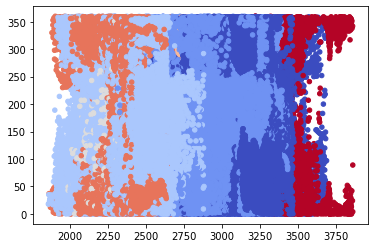

In [102]:
plt.scatter(covtype_X[:, 0], covtype_X[:, 1], c=covtype_y, cmap=plt.cm.coolwarm, s=20);

예시

In [97]:
X, y = make_blobs(n_samples=1000)

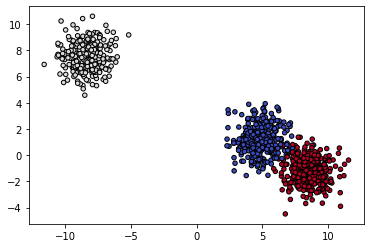

In [98]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

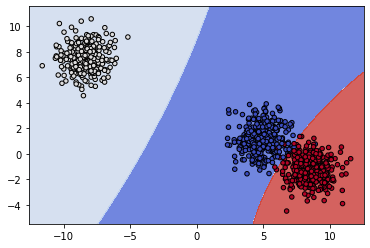

In [99]:
model = GaussianNB()
model.fit(X, y)

xx, yy = make_meshgrid(X[:, 0], X[:, 1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

# 베르누이 나이브 베이즈
- 입력 특성이 베르누이 분포ㄹ에 의해 생성된 이진 값을 갖는다고 가정

Count Vectorizer

In [105]:
model = BernoulliNB()
model.fit(X_train_count, y_train)

predict = model.predict(X_train_count)
acc = metrics.accuracy_score(y_train, predict) # 정확도만 보면 안돼
f1 = metrics.f1_score(y_train, predict, average=None) # 재현율과 정밀도의 조화평균값

print('Train Accuracy : {}'.format(acc))
print('Train F1 Score : {}'.format(f1))

predict = model.predict(X_test_count)
acc = metrics.accuracy_score(y_test, predict)
f1 = metrics.f1_score(y_test, predict, average=None)

print('Test Accuracy : {}'.format(acc))
print('Test F1 Score : {}'.format(f1))

Train Accuracy : 0.7821283365741559
Train F1 Score : [0.80096502 0.8538398  0.13858268 0.70686337 0.85220126 0.87944493
 0.51627694 0.84532672 0.89064976 0.87179487 0.94561404 0.91331546
 0.84627832 0.89825848 0.9047619  0.79242424 0.84693878 0.84489796
 0.67329545 0.14742015]
Test Accuracy : 0.6307753584705258
Test F1 Score : [0.47086247 0.60643564 0.01       0.56014047 0.6953405  0.70381232
 0.44829721 0.71878646 0.81797753 0.81893491 0.90287278 0.74794521
 0.61647059 0.64174455 0.76967096 0.63555114 0.64285714 0.77971474
 0.31382979 0.00793651]


Hash Vectorizer

In [106]:
model = BernoulliNB()
model.fit(X_train_hash, y_train)

predict = model.predict(X_train_hash)
acc = metrics.accuracy_score(y_train, predict) # 정확도만 보면 안돼
f1 = metrics.f1_score(y_train, predict, average=None) # 재현율과 정밀도의 조화평균값

print('Train Accuracy : {}'.format(acc))
print('Train F1 Score : {}'.format(f1))

predict = model.predict(X_test_hash)
acc = metrics.accuracy_score(y_test, predict)
f1 = metrics.f1_score(y_test, predict, average=None)

print('Test Accuracy : {}'.format(acc))
print('Test F1 Score : {}'.format(f1))

Train Accuracy : 0.5951917977726711
Train F1 Score : [0.74226804 0.49415205 0.45039019 0.59878155 0.57327935 0.63929619
 0.35390947 0.59851301 0.72695347 0.68123862 0.79809524 0.70532319
 0.54703833 0.66862745 0.61889927 0.74707471 0.6518668  0.60485269
 0.5324165  0.54576271]
Test Accuracy : 0.4430430164630908
Test F1 Score : [0.46678636 0.33826638 0.29391892 0.45743329 0.41939121 0.46540881
 0.34440068 0.46464646 0.62849873 0.53038674 0.63782051 0.55251799
 0.32635983 0.34266886 0.46105919 0.61780105 0.46197991 0.54591837
 0.27513228 0.3307888 ]


Tfidf Vectorizer

In [107]:
model = BernoulliNB()
model.fit(X_train_tfidf, y_train)

predict = model.predict(X_train_tfidf)
acc = metrics.accuracy_score(y_train, predict) # 정확도만 보면 안돼
f1 = metrics.f1_score(y_train, predict, average=None) # 재현율과 정밀도의 조화평균값

print('Train Accuracy : {}'.format(acc))
print('Train F1 Score : {}'.format(f1))

predict = model.predict(X_test_tfidf)
acc = metrics.accuracy_score(y_test, predict)
f1 = metrics.f1_score(y_test, predict, average=None)

print('Test Accuracy : {}'.format(acc))
print('Test F1 Score : {}'.format(f1))

Train Accuracy : 0.7821283365741559
Train F1 Score : [0.80096502 0.8538398  0.13858268 0.70686337 0.85220126 0.87944493
 0.51627694 0.84532672 0.89064976 0.87179487 0.94561404 0.91331546
 0.84627832 0.89825848 0.9047619  0.79242424 0.84693878 0.84489796
 0.67329545 0.14742015]
Test Accuracy : 0.6307753584705258
Test F1 Score : [0.47086247 0.60643564 0.01       0.56014047 0.6953405  0.70381232
 0.44829721 0.71878646 0.81797753 0.81893491 0.90287278 0.74794521
 0.61647059 0.64174455 0.76967096 0.63555114 0.64285714 0.77971474
 0.31382979 0.00793651]


시각화

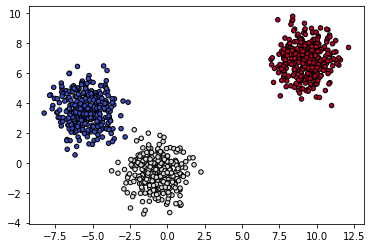

In [122]:
X, y = make_blobs(n_samples=1000)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

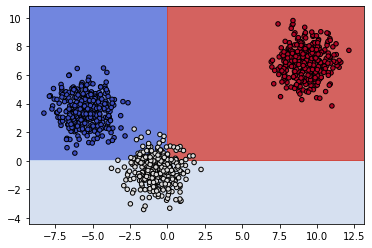

In [123]:
model = BernoulliNB()
model.fit(X, y)

xx, yy = make_meshgrid(X[:, 0], X[:, 1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

# 다항 나이브 베이즈
- 입력 특성이 다항 분포에 의해 생성된 빈도수 값을 갖는다고 가정

Count Vector

In [124]:
model = MultinomialNB()
model.fit(X_train_count, y_train)

predict = model.predict(X_train_count)
acc = metrics.accuracy_score(y_train, predict) # 정확도만 보면 안돼
f1 = metrics.f1_score(y_train, predict, average=None) # 재현율과 정밀도의 조화평균값

print('Train Accuracy : {}'.format(acc))
print('Train F1 Score : {}'.format(f1))

predict = model.predict(X_test_count)
acc = metrics.accuracy_score(y_test, predict)
f1 = metrics.f1_score(y_test, predict, average=None)

print('Test Accuracy : {}'.format(acc))
print('Test F1 Score : {}'.format(f1))

Train Accuracy : 0.9245182959165635
Train F1 Score : [0.95228426 0.904      0.25073746 0.81402003 0.96669513 0.88350983
 0.90710383 0.97014925 0.98567818 0.99325464 0.98423237 0.95399516
 0.95703454 0.98319328 0.98584513 0.95352564 0.97307002 0.97467249
 0.95157895 0.86526946]
Test Accuracy : 0.7728359001593202
Test F1 Score : [0.77901431 0.7008547  0.00501253 0.64516129 0.79178082 0.73370166
 0.76550681 0.88779285 0.93951094 0.91390728 0.94594595 0.78459938
 0.72299169 0.84635417 0.86029412 0.80846561 0.78665077 0.89281211
 0.60465116 0.48695652]


Tfidf Vector

In [125]:
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

predict = model.predict(X_train_tfidf)
acc = metrics.accuracy_score(y_train, predict) # 정확도만 보면 안돼
f1 = metrics.f1_score(y_train, predict, average=None) # 재현율과 정밀도의 조화평균값

print('Train Accuracy : {}'.format(acc))
print('Train F1 Score : {}'.format(f1))

predict = model.predict(X_test_tfidf)
acc = metrics.accuracy_score(y_test, predict)
f1 = metrics.f1_score(y_test, predict, average=None)

print('Test Accuracy : {}'.format(acc))
print('Test F1 Score : {}'.format(f1))

Train Accuracy : 0.9326498143892522
Train F1 Score : [0.87404162 0.95414462 0.95726496 0.92863002 0.97812773 0.97440273
 0.91090909 0.97261411 0.98659966 0.98575021 0.98026316 0.94033413
 0.9594478  0.98032506 0.97755611 0.77411003 0.93506494 0.97453907
 0.90163934 0.45081967]
Test Accuracy : 0.7738980350504514
Test F1 Score : [0.63117871 0.72       0.72778561 0.72104019 0.81309686 0.81643836
 0.7958884  0.88135593 0.93450882 0.91071429 0.92917167 0.73583093
 0.69732938 0.81907433 0.86559803 0.60728118 0.76286353 0.92225201
 0.57977528 0.24390244]


시각화

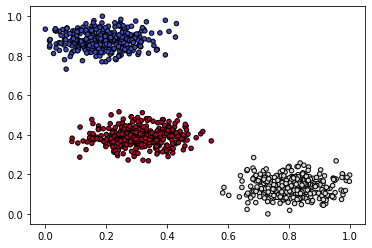

In [131]:
X, y = make_blobs(n_samples=1000)

scaler = MinMaxScaler() # Negative values in data passed to MultinomialNB (input X)
X = scaler.fit_transform(X)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

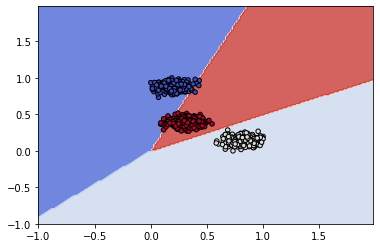

In [132]:
model = MultinomialNB()
model.fit(X, y) # Negative values in data passed to MultinomialNB (input X)

xx, yy = make_meshgrid(X[:, 0], X[:, 1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');